In [3]:
import pandas as pd
import os
import tifffile as tiff
import matplotlib.pyplot as plt
import pathophys as pp
import numpy as np
import math
import seaborn as sns

def getimfolder(experiment):
    import os
    basedir = ""
    data = "E:\Raphael\Data"
    for folder in os.listdir(data):
        if str(experiment) in folder:
            basedir = os.path.join(data, folder)
    return basedir

experiment = 3
basedir = getimfolder(experiment)

In [2]:
import pandas as pd
import os
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import nd2
import cc3d
import pickle

from scipy import signal
from scipy import stats
from scipy import ndimage as ndi
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from scipy.spatial import KDTree

from skimage.util import img_as_float, img_as_int
from skimage.feature import peak_local_max
from skimage import filters

from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize

from skimage import morphology
from skimage.filters import threshold_multiotsu, threshold_otsu, sobel
from skimage.segmentation import watershed, expand_labels, mark_boundaries, clear_border, random_walker
from skimage.filters import rank, laplace, gaussian
from skimage.measure import regionprops, regionprops_table
from skimage import measure
from skimage import restoration
from skimage.exposure import rescale_intensity
from skimage.draw import disk

model = StarDist2D.from_pretrained('2D_versatile_fluo')

def rescale_before(img, pixlenimg):
    from skimage.transform import rescale
    pixlensd = 0.3488
    scaling_factor = pixlenimg/pixlensd
    image_rescaled = rescale(img, scaling_factor, anti_aliasing=True)
    return image_rescaled

def rescale_after(img, dims):
    from skimage.transform import resize
    image_resized = resize(img, dims, preserve_range=True, order=0, anti_aliasing=False).astype('uint8')
    return image_resized

def segment_cells(cells, labels):
    t = threshold_multiotsu(cells)
    minimg = np.min(cells)
    binary = cells > (2*t[0]+minimg)/3
    binary = ndi.binary_fill_holes(binary)
    cellL = watershed(-cells, markers = labels, mask = binary)
    return cellL

def segment_slice(DAPIimg,CELLimg,xlen, model):
    if model == None:
        model = StarDist2D.from_pretrained('2D_versatile_fluo')
    img_rescaled_DAPI = rescale_before(DAPIimg, xlen)
    labelssd, _ = model.predict_instances(normalize(img_rescaled_DAPI))
    cells = segment_cells(rescale_before(CELLimg, xlen),labelssd)
    labels_rescaled = rescale_after(labelssd, (500,500))
    cellL = rescale_after(cells, (500,500))
    return labels_rescaled,cellL

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


(4, 43, 49)
(4, 55, 55)
(4, 51, 55)
(4, 79, 82)


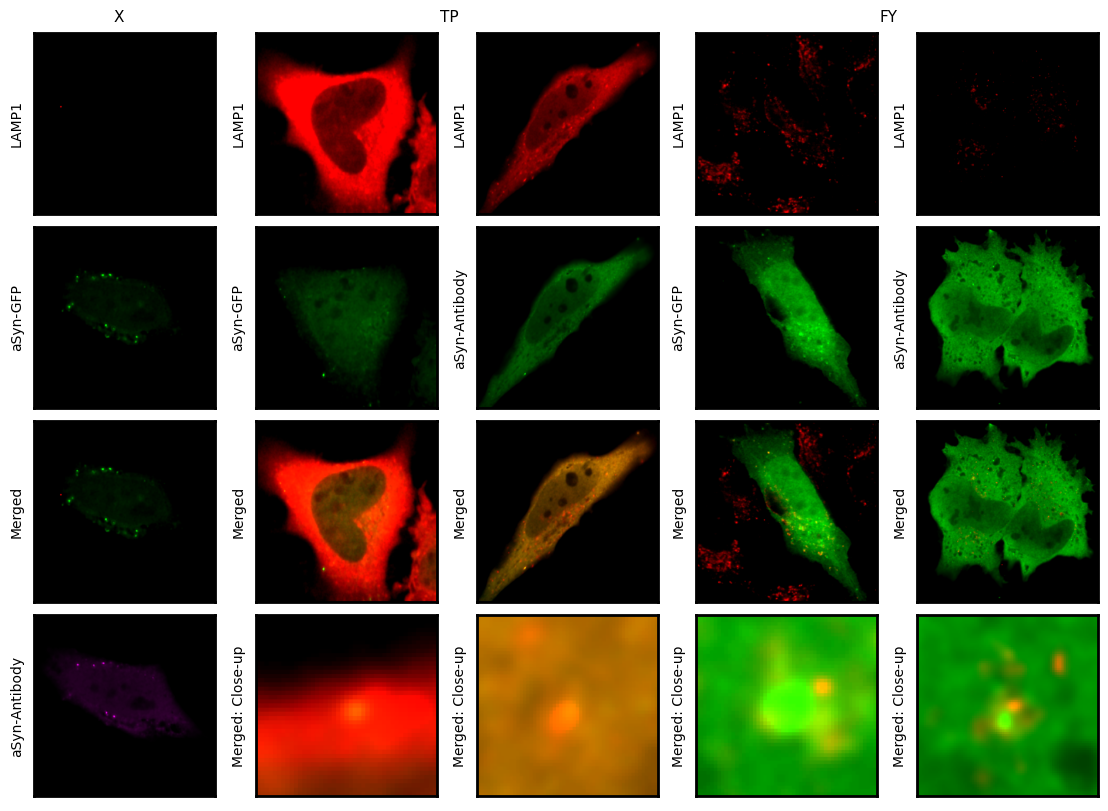

In [35]:
def crop_square(img):
    mins = np.min(img[1,:,:].shape)
    return img[:,:mins,:mins]


def get_images(title, ranges):
    dic={4:[33.46,38.55,2.66,3.594],5:[21.33,20.96,6.66,5.98],2:[31.81,17.66,4.56,4.26],3:[42.67,13.25,5.84,5.24]}
    imagedir = os.path.join(basedir,"Img_Final_LAMP1")
    testimg = tiff.imread(os.path.join(imagedir,str(title)+".tif")).astype(np.uint8)[0,:,:,:]
    testimg = rescale_after(testimg, (4,500,500))
    cropimg = crop_square(testimg)
    xlen =0.074865427
    #Nl,Cl = segment_slice(cropimg[2,:,:],cropimg[1,:,:],xlen, model)
   # Nl = np.zeros(cropimg.shape, dtype = np.uint8)
    #Cl = np.zeros(cropimg.shape, dtype = np.uint8)
    #for i in range(cropimg.shape[0]):
        #Nl[i,:,:] = nl
        #Cl[i,:,:] = cl
    im1 = np.zeros((3,500,500), dtype = np.uint8)
    im1[0,:,:] = cropimg[0,:,:]
    im1[0,:,:] = rescale_intensity(im1[0,:,:], in_range=ranges[0])
    im1 = np.transpose(im1,(1,2,0))

    im2 = np.zeros((3,500,500), dtype = np.uint8)
    im3 = np.zeros((3,500,500), dtype = np.uint8)
    if title in [3,5]:
        im2[1,:,:] = cropimg[3,:,:]
        im2[1,:,:] = rescale_intensity(im2[1,:,:], in_range=ranges[2])
        im2 = np.transpose(im2,(1, 2, 0))
        im3[0,:,:] = cropimg[0,:,:]
        im3[0,:,:] = rescale_intensity(im3[0,:,:], in_range=ranges[0])
        im3[1,:,:] = cropimg[3,:,:]
        im3[1,:,:] = rescale_intensity(im3[1,:,:], in_range=ranges[2])
        im3 = np.transpose(im3,(1, 2, 0))
    else:
        im2[1,:,:] = cropimg[1,:,:]
        im2[1,:,:] = rescale_intensity(im2[1,:,:], in_range=ranges[1])
        im2 = np.transpose(im2,(1, 2, 0))
        im3[0,:,:] = cropimg[0,:,:]
        im3[0,:,:] = rescale_intensity(im3[0,:,:], in_range=ranges[0])
        im3[1,:,:] = cropimg[1,:,:]
        im3[1,:,:] = rescale_intensity(im3[1,:,:], in_range=ranges[1])
        im3 = np.transpose(im3,(1, 2, 0))
    
    
    if title == 1:
        im4 = np.zeros((3,500,500), dtype = np.uint8)
        im4[0,:,:] = cropimg[3,:,:]
        im4[2,:,:] = cropimg[3,:,:]
        im4[0,:,:] = rescale_intensity(im4[0,:,:], in_range=ranges[2])
        im4[2,:,:] = rescale_intensity(im4[2,:,:], in_range=ranges[2])
        im4 = np.transpose(im4,(1,2,0))
        return [im1,im2,im3,im4]
    
    smallimage = tiff.imread(os.path.join(imagedir,str(title)+"_small.tif")).astype(np.uint8)[0,:,:,:]
    print(smallimage.shape)
    smallimage = crop_square(smallimage)
    smallimage = rescale_after(smallimage, (4,500,500))
    
    im4 = np.zeros((3,500,500), dtype = np.uint8)
    if title in [3,5]:
        im4[1,:,:] = smallimage[3,:,:]
        im4[1,:,:] = rescale_intensity(im4[1,:,:], in_range=ranges[2])
    else:
        im4[1,:,:] = smallimage[1,:,:]
        im4[1,:,:] = rescale_intensity(im4[1,:,:], in_range=ranges[1])
    im4[0,:,:] = smallimage[0,:,:]
    
    im4[0,:,:] = rescale_intensity(im4[0,:,:], in_range=ranges[0])
    im4 = np.transpose(im4,(1,2,0))
    return [im1,im2,im3,im4]

plt.rcParams['lines.linewidth'] = 10
ranges = [(30, 150),(30, 170),(20, 200),(30, 150)]
fig = plt.figure(constrained_layout=True, figsize=(11,8))
subfigs = fig.subfigures(1, 3, wspace=0, width_ratios=[1,2,2])
axBL = subfigs[0].subplots(4, 1, sharex=True, sharey=True)
subfigs[0].suptitle("X", fontsize=11)
titleBL = 1
stackBL = get_images(titleBL, ranges)
axBL[0].imshow(stackBL[0])
axBL[0].set_ylabel("LAMP1")
axBL[1].imshow(stackBL[1])
axBL[1].set_ylabel("aSyn-GFP")
axBL[2].imshow(stackBL[2])
axBL[2].set_ylabel("Merged")
axBL[3].imshow(stackBL[3])
axBL[3].set_ylabel("aSyn-Antibody")
for ax in axBL:
    ax.set_xticks([])
    ax.set_yticks([])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)


axX1 = subfigs[1].subplots(4, 2, sharex=True, sharey=True)
subfigs[1].suptitle("TP", fontsize=11)
titleX1 = 2
stackX1 = get_images(titleX1, ranges)
axX1[0,0].imshow(stackX1[0])
axX1[0,0].set_ylabel("LAMP1")
axX1[1,0].imshow(stackX1[1])
axX1[1,0].set_ylabel("aSyn-GFP")
axX1[2,0].imshow(stackX1[2])
axX1[2,0].set_ylabel("Merged")
axX1[3,0].imshow(stackX1[3])
axX1[3,0].set_ylabel("Merged: Close-up")

titleX2 = 3
stackX2 = get_images(titleX2, ranges)
axX1[0,1].imshow(stackX2[0])
axX1[0,1].set_ylabel("LAMP1")
axX1[1,1].imshow(stackX2[1])
axX1[1,1].set_ylabel("aSyn-Antibody")
axX1[2,1].imshow(stackX2[2])
axX1[2,1].set_ylabel("Merged")
axX1[3,1].imshow(stackX2[3])
axX1[3,1].set_ylabel("Merged: Close-up")
for ax in axX1.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

axTP1 = subfigs[2].subplots(4, 2, sharex=True, sharey=True)
subfigs[2].suptitle("FY", fontsize=11)
titleTP1 = 4
stackTP1 = get_images(titleTP1, ranges)
axTP1[0,0].imshow(stackTP1[0])
axTP1[0,0].set_ylabel("LAMP1")
axTP1[1,0].imshow(stackTP1[1])
axTP1[1,0].set_ylabel("aSyn-GFP")
axTP1[2,0].imshow(stackTP1[2])
axTP1[2,0].set_ylabel("Merged")
axTP1[3,0].imshow(stackTP1[3])
axTP1[3,0].set_ylabel("Merged: Close-up")

titleTP2 = 5
stackT2 = get_images(titleTP2, ranges)
axTP1[0,1].imshow(stackT2[0])
axTP1[0,1].set_ylabel("LAMP1")
axTP1[1,1].imshow(stackT2[1])
axTP1[1,1].set_ylabel("aSyn-Antibody")
axTP1[2,1].imshow(stackT2[2])
axTP1[2,1].set_ylabel("Merged")
axTP1[3,1].imshow(stackT2[3])
axTP1[3,1].set_ylabel("Merged: Close-up")
for ax in axTP1.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

plt.show()

In [36]:
rdf = pd.read_csv(os.path.join(basedir,"Ripley_parametric.csv"))
rdf.head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,CID,S,V,C1,C2,radius,Group2,Group1,M,S_wave,p,a,b,O
0,0,0.0,0,0,17,218.265756,30.308358,aSyn_GFP,LAMP1,1,LAMP1,FY,3.141593,7.097849,538.129065,0.311938,66.819362,351.244207
1,1,2.0,2,2,17,638.750087,175.218069,aSyn_GFP,LAMP1,2,LAMP1,FY,12.566371,3.573739,538.129065,0.311938,66.819362,351.244207
2,2,4.0,4,4,17,944.550370,496.376332,aSyn_GFP,LAMP1,3,LAMP1,FY,28.274334,1.845930,538.129065,0.311938,66.819362,351.244207
3,3,6.0,6,6,17,1249.910609,1003.806841,aSyn_GFP,LAMP1,4,LAMP1,FY,50.265482,1.195096,538.129065,0.311938,66.819362,351.244207
4,4,8.0,8,8,17,1581.210301,1820.855222,aSyn_GFP,LAMP1,5,LAMP1,FY,78.539816,0.825255,538.129065,0.311938,66.819362,351.244207


2550932653.py (4): Boolean Series key will be reindexed to match DataFrame index.


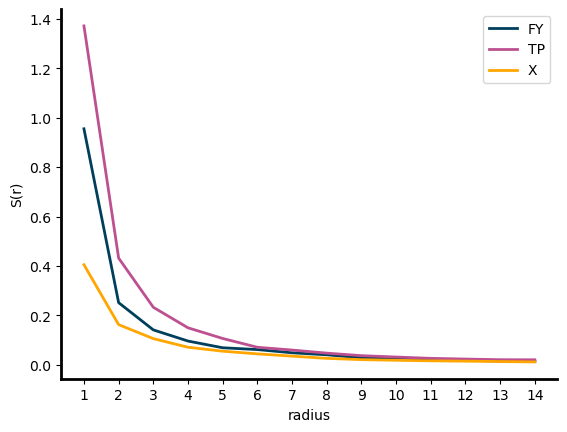

,R,S,G,M,Ssd
0,1,0.954930,FY,3.141593,1788.481851
1,2,0.251673,FY,12.566371,314.450008
2,3,0.141471,FY,28.274334,79.411534
3,4,0.096350,FY,50.265482,32.380500
4,5,0.069152,FY,78.539816,15.608422
5,6,0.061894,FY,113.097336,8.145463
6,7,0.048796,FY,153.938040,5.867331
7,8,0.040815,FY,201.061930,3.039570
8,9,0.028513,FY,254.469005,3.758941
9,10,0.028648,FY,314.159265,1.308288


In [54]:
params = pp.loadparams()
ax = plt.subplot(111)
def plot_ripley_S(rdf,c1,c2,g2):
    olddf = rdf[rdf["Group2"]==g2][rdf["C1"]==c1][rdf["C2"]==c2]
    group = olddf.groupby(["Group1","radius"])
    S = np.array(group.median()["S_wave"])
    Ssd = np.array(group.std()["S_wave"])
    M = np.array(group.median()["M"])
    V = np.array(group.median()["V"])
    MV = V+M
    K = np.array(list(group.groups.keys()))
    R = K[:,1]
    G = K[:,0]
    df= pd.DataFrame(data={"R":R,"S":S,"G":G,"M":M,"Ssd":Ssd})
    mi = 0
    for g in df["G"].unique():
        y = df["S"][df["G"]==g]
        x = df["R"][df["G"]==g]
        yerr = df["Ssd"][df["G"]==g]*2
        ax.plot(x,y,label=g, color=params["Colors"][mi],linewidth=2)
        #plt.errorbar(x,y,yerr=yerr)
        ax.legend()
        if mi == 0:
            yt = df["M"][df["G"]==g]
            xt = df["R"][df["G"]==g]
            #plt.plot(xt,yt,label="Mean")
            #plt.legend()
        mi= mi+1
    ax.set_xlabel("radius")
    ax.set_ylabel("S(r)")
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
        if axis in ['top','right']:
            ax.spines[axis].set_visible(False)
    plt.show()
    return df

plot_ripley_S(rdf,"aSyn_GFP","LC3","LC3")